In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [2]:
clf_name = "mlp"

from tpot.builtins import OneHotEncoder, StackingEstimator, ZeroCount
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

from sklearn.metrics import average_precision_score, plot_precision_recall_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier

logistic = LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")


pipe = (MinMaxScaler(),
            VarianceThreshold(threshold=0.1),
            ZeroCount(),
            RFE(logistic),
            MLPClassifier(alpha=0.01, learning_rate_init=0.01))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

from scipy.stats import pearsonr

sns.set_style("darkgrid")
np.random.seed(930525)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 200)

warnings.simplefilter('once')

%matplotlib inline
%load_ext watermark
%watermark --iversions

pandas  1.1.4
numpy   1.19.5
seaborn 0.10.1



In [4]:
import plot_utils as pu

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import requests

from io import StringIO

In [6]:
from collections import defaultdict

url = requests.get('https://docs.google.com/spreadsheets/d/1KO_wGiEagJ8PMO2BzSDI1IXHYO4RHZMMSWXlT48peiQ/export?format=csv')
csv_raw = StringIO(url.text)
df_truth = pd.read_csv(csv_raw)

inf_tax_file = "/mnt/btrfs/data/gtdb_95/gtdb_genomes_reps_r95/r95.gtdb.tax"

In [7]:
df_tax = pd.read_csv(inf_tax_file, names=["assembly_accession", "tax"], sep="\t")

df_tax["species"] = [";".join(_.split(";")[:7]) for _ in df_tax.tax]
df_tax["genus"] = [";".join(_.split(";")[:6]) for _ in df_tax.tax]
df_tax["family"] = [";".join(_.split(";")[:5]) for _ in df_tax.tax]

accession_to_genus = dict()
for t in df_tax.itertuples():
    accession_to_genus[t.assembly_accession] = t.genus.split(";")[-1]

In [8]:
from glob import glob
import os

files = glob("/mnt/btrfs/data/type_1/species_mc/b6_capitalist_split_by_sample/*.extra.tree.csv")

dfs = []
for file in files:
    name = '_'.join(os.path.basename(file).split('.')[:-4])
    df = pd.read_csv(file, index_col = 0)
    df['dataset'] = name
    dfs.append(df)
df_type_1_features = pd.concat(dfs)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (84,88,97,106,218,222,231,240) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
# Build the true species accessions
dd = defaultdict(set)

dd_genus = defaultdict(set)
for group, df in df_truth.groupby('dataset'):
    mask_nan = df_truth['database_accession'].astype(str) == 'nan'
    
    for row in df.loc[mask_nan].itertuples():
        # get the genus of the nans
        dd_genus[group].add("g__" + row.name.replace("_", " ").split()[0])
        dd_genus[group].add("g__" + row.homotypic_synonym.replace("_", " ").split()[0])
    
    dd[group] = set(df.loc[~mask_nan, "database_accession"].values)

In [10]:
rows = []
for i, t in df_type_1_features.iterrows():
    if t['assembly_accession'] in dd[t['dataset']]:
        rows.append(True)
    else:
        rows.append(False)
df_type_1_features["truth"] = rows

# Assembly Sequence Training Data

In [11]:
files = glob("/mnt/btrfs/data/type_1/simulation_cv/*.extra.csv")

dfs = []
for file in files:
    name = '.'.join(os.path.basename(file).split('.')[1:-3])
    df = pd.read_csv(file, index_col = 0)
    df['dataset'] = name
    dfs.append(df)
df_assembly_features = pd.concat(dfs)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (84,88,97,105,106,218,222,231,240) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
df_assembly_truth = pd.read_csv("../data/simulation.truth.csv")

In [13]:
d_assembly_truth = dict()
for group, df in df_assembly_truth.groupby("basename"):
    d_assembly_truth[group] = set(df["closest_assembly_accession"])

In [14]:
rows = []
for i, t in df_assembly_features.iterrows():
    if t['assembly_accession'] in d_assembly_truth[t['dataset']]:
        rows.append(True)
    else:
        rows.append(False)
df_assembly_features["truth"] = rows

In [15]:
df_assembly_features['relative_abundance'] = df_assembly_features['hits'] / df_assembly_features.groupby('dataset')['hits'].transform('sum')

df_assembly_features['dataset_cat'] = "assembly"
df_assembly_features.reset_index(inplace=True, drop=True)

In [16]:
df_type_1_features['relative_abundance'] = df_type_1_features['hits'] / df_type_1_features.groupby('dataset')['hits'].transform('sum')

df_type_1_features.reset_index(inplace=True, drop=True)
df_type_1_features['dataset_cat'] = pd.Series([_.split("_")[0] for _ in df_type_1_features['dataset']], dtype='category')

categories = df_type_1_features['dataset_cat'].cat.categories

In [17]:
filter_test = df_type_1_features['dataset_cat'] == "zymo"

In [18]:
train = df_type_1_features.loc[~filter_test, :].copy().reset_index(drop=True)
test = df_type_1_features.loc[filter_test, :].copy().reset_index(drop=True)

In [19]:
mask_in = np.array([_.split(".")[1] in ["0", "1", "2"] for _ in df_assembly_features.dataset])

In [20]:
train_assembly = df_assembly_features.loc[mask_in, :].copy().reset_index(drop=True)
test_assembly = df_assembly_features.loc[~mask_in, :].copy().reset_index(drop=True)

In [21]:
# df_train = pd.concat([train_assembly, train])
# df_test = pd.concat([test_assembly, test])

In [22]:
df_train = pd.concat([train_assembly, train])
df_test = pd.concat([test_assembly, test])

In [23]:
df_train['dataset_cat'] = df_train["dataset_cat"].astype('category')

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import PredefinedSplit

In [25]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

cv = PredefinedSplit(df_train['dataset_cat'].cat.codes)
categories = df_train['dataset_cat'].cat.categories

X = df_train.loc[:, ["relative_abundance"]].copy()
X.reset_index(inplace=True, drop=True)
y = df_train.loc[:, ["truth"]].copy()
y.reset_index(inplace=True, drop=True)


precisions = []
average_precisions = []
mean_recall = np.linspace(0, 1, 100)
classifiers = []

for i, (train, test) in enumerate(cv.split(X, y)):
    clf = LogisticRegression(class_weight="balanced")
    clf.fit(X.loc[train], y.loc[train])
    classifiers.append(clf)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array 

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset: assembly
F1: 0.2779966235227912
Precision: 0.9391634980988594
Recall: 0.16314398943196828
Num Predicted: 263
Dataset: dual
F1: 0.8444444444444443
Precision: 0.7307692307692307
Recall: 1.0
Num Predicted: 26
Dataset: gis
F1: 0.6486486486486486
Precision: 0.6666666666666666
Recall: 0.631578947368421
Num Predicted: 18
Dataset: hmp
F1: 0.6575342465753425
Precision: 0.7272727272727273
Recall: 0.6
Num Predicted: 33
Dataset: mbarc
F1: 0.8695652173913044
Precision: 1.0
Recall: 0.7692307692307693
Num Predicted: 20


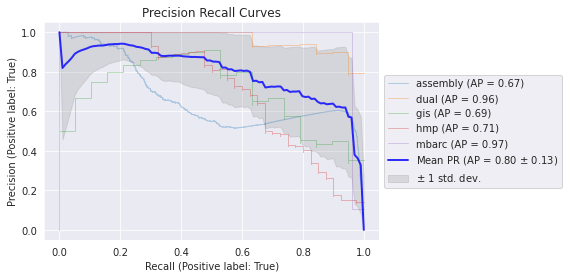

In [26]:
fig, ax = plt.subplots()
for i, ((train, test), classifier) in enumerate(zip(cv.split(X, y), classifiers)):
    viz = plot_precision_recall_curve(classifier, X.loc[test], y.loc[test],
                     name=f'{categories[i]}',
                     alpha=0.3, lw=1, ax=ax)
    interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
    interp_precision[0] = 1.0
    precisions.append(interp_precision)
    average_precisions.append(viz.average_precision)
    y_pred = classifier.predict(X.loc[test])
    print(f"Dataset: {categories[i]}")
    print(f"F1: {f1_score(y.loc[test], y_pred)}")
    print(f"Precision: {precision_score(y.loc[test], y_pred)}")
    print(f"Recall: {recall_score(y.loc[test], y_pred)}")
    print(f"Num Predicted: {y_pred.sum()}")
    

mean_precision = np.mean(precisions, axis=0)
mean_precision[-1] = 0.0
mean_average_precisions = np.mean(average_precisions)
std_average_precisions = np.std(average_precisions)

ax.plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_average_precisions, std_average_precisions),
        lw=2, alpha=.8)

mean_recall_cap = mean_recall.copy()
mean_precision_cap = mean_precision.copy()
mean_average_precisions_cap = mean_average_precisions.copy()
std_average_precisions_cap = std_average_precisions.copy()

# calculate the no skill line as the proportion of the positive class
# no_skill = len(y[y==False]) / len(y)
# # plot the no skill precision-recall curve
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ( AP = {no_skill:.5f})')

std_precisions = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precisions, 1)
precisions_lower = np.maximum(mean_precision - std_precisions, 0)
ax.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
precisions_upper_cap = precisions_upper.copy()
precisions_lower_cap = precisions_lower.copy()

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Precision Recall Curves")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


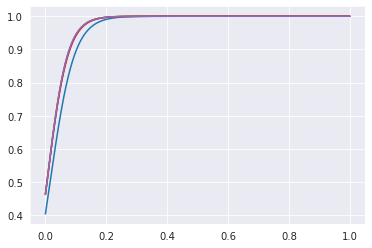

In [27]:
fig, ax = plt.subplots()
for clf in classifiers:
    plt.plot(np.arange(0, 1, .001), clf.predict_proba(np.atleast_2d(np.arange(0, 1, .001)).T)[:, 1])
plt.show()

In [28]:
features = ['hits',
 'percent_coverage',
 'mean_coverage',
 'sd_coverage',
 'percent_binned_coverage',
 'mean_binned_coverage',
 'sd_binned_coverage',
 'expected_percent_coverage',
 'shannon_entropy',
 'percent_max_uncovered_region',
 'largest_pileup',
 'largest_binned_pileup',
 'gc_content',
 'total_genome_length',
 'ungapped_genome_length',
 'num_n_groups',
 'consecutive_ns',
 'tree_dist',
 'tree_top_dist',
 'gf_checkm_completeness',
 'gf_checkm_contamination',
 'relative_abundance',
 'tree_hits',
 'tree_percent_coverage',
 'tree_mean_coverage',
 'tree_sd_coverage',
 'tree_percent_binned_coverage',
 'tree_mean_binned_coverage',
 'tree_sd_binned_coverage',
 'tree_expected_percent_coverage',
 'tree_shannon_entropy',
 'tree_percent_max_uncovered_region',
 'tree_largest_pileup',
 'tree_largest_binned_pileup',
 'tree_dist',
 'tree_top_dist'
]

# features = [
#  'gf_checkm_completeness',
#  'gf_checkm_contamination',
#  'tree_relative_abundance'
# ]

# features = ['relative_abundance']

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
X = df_train[features + ["assembly_accession", "dataset", "truth", "dataset_cat"]]

# X = X.replace([np.inf, -np.inf], np.nan)
# X = X.loc[:, features].dropna()

cv = PredefinedSplit(X['dataset_cat'].cat.codes)
X = X.loc[:, features].copy()
X.reset_index(inplace=True, drop=True)

y = df_train.loc[:, "truth"]
y.reset_index(inplace=True, drop=True)

In [30]:
precisions = []
average_precisions = []
mean_recall = np.linspace(0, 1, 100)
classifiers = []

# columns = rfecv.ranking_

# df_X_transf = pd.DataFrame(X_transf[:, columns == 1], columns = X.columns[columns == 1])

# X_transf = rfecv.transform(X)
# X_transf = X_transf.copy().values
X_transf = X.copy().values
# X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)

for i, (train, test) in enumerate(cv.split(X_transf, y)):
#     clf = RandomForestClassifier(n_estimators=100, max_features=.2, min_samples_leaf=17, min_samples_split=9, bootstrap=False, criterion="gini", class_weight="balanced_subsample")
#     clf = ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_features=0.8, min_samples_leaf=4, min_samples_split=20, n_estimators=100)
    clf = make_pipeline(*pipe)
#     clf = make_pipeline(
# #         MinMaxScaler(),
# #         RFE(LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")),
#         StackingEstimator(estimator=XGBClassifier(learning_rate=0.01, max_depth=5, min_child_weight=13, n_estimators=100, n_jobs=1, scale_pos_weight=50, subsample=0.6500000000000001, verbosity=0)),
#         ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion="gini", max_features=0.45, min_samples_leaf=19, min_samples_split=14, n_estimators=100)
#     )

#     clf = make_pipeline(
#         VarianceThreshold(threshold=0.1),
#         ZeroCount(),
#         RFE(LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")),
#         StackingEstimator(estimator=
#             GradientBoostingClassifier(learning_rate=1.0, max_depth=2, max_features=0.7000000000000001, min_samples_leaf=20, min_samples_split=5, n_estimators=100, subsample=0.05)),
#             RandomForestClassifier(bootstrap=True, class_weight=None, criterion="gini", max_features=1.0, min_samples_leaf=8, min_samples_split=15, n_estimators=100)
# )

#     clf = LogisticRegression(penalty="l1", solver="liblinear", fit_intercept=True, dual=False, tol=0.001, class_weight="balanced")
    clf.fit(X_transf[train], y.loc[train])
    classifiers.append(clf)

# Save classifier from entire pipeline

In [31]:
import joblib

clf = make_pipeline(*pipe)
clf.fit(X_transf[train], y.loc[train])

joblib.dump(clf, f'../data/clf.sklearn.all.{clf_name}.pkl', compress=9)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['../data/clf.sklearn.all.mlp.pkl']

In [32]:
import joblib

for i, classifier in enumerate(classifiers):
    joblib.dump(classifier, f'../data/clf.sklearn.{categories[i]}.{clf_name}.pkl', compress=9)

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset: assembly
F1: 0.8824862415021043
Precision: 0.8653968253968254
Recall: 0.9002642007926024
Num Predicted: 1575
Dataset: dual
F1: 0.6666666666666666
Precision: 0.5517241379310345
Recall: 0.8421052631578947
Num Predicted: 29
Dataset: gis
F1: 0.6785714285714285
Precision: 0.5135135135135135
Recall: 1.0
Num Predicted: 37
Dataset: hmp
F1: 0.6226415094339622
Precision: 0.5
Recall: 0.825
Num Predicted: 66
Dataset: mbarc
F1: 0.8135593220338984
Precision: 0.7272727272727273
Recall: 0.9230769230769231
Num Predicted: 33


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


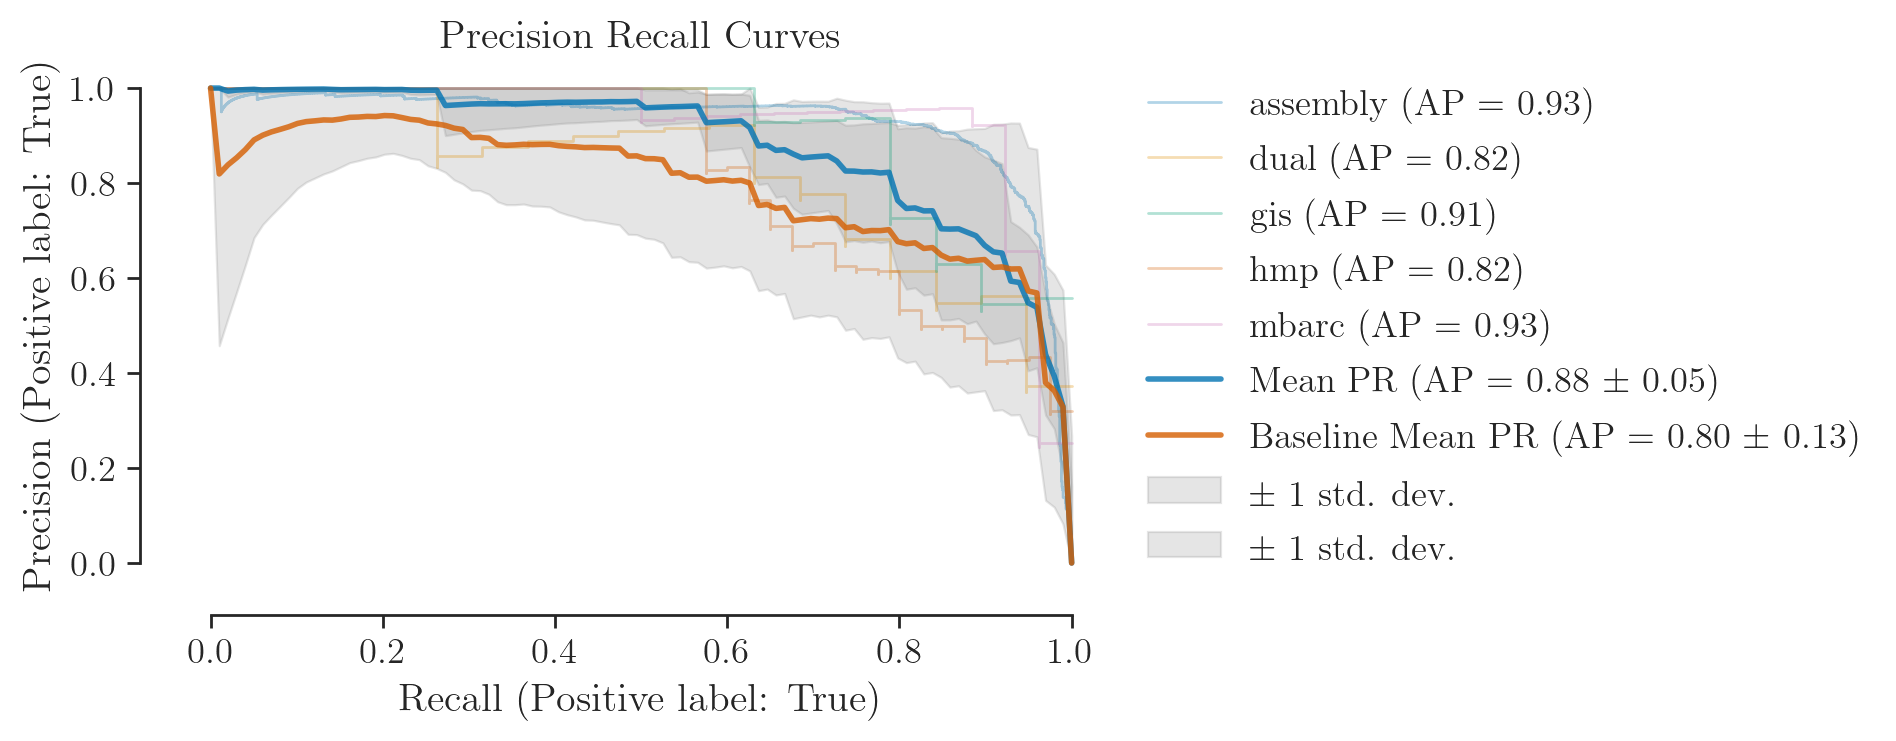

In [33]:
sns.set(context="paper", style="ticks", palette="colorblind", font='serif', font_scale=1.5, color_codes=True, rc=pu.figure_setup())

ax.yaxis.grid(True)
ax.xaxis.grid(False)
fig_size = pu.get_fig_size(15, 10)

fig, ax = plt.subplots(figsize=fig_size)

for i, ((train, test), classifier) in enumerate(zip(cv.split(X_transf, y), classifiers)):
    viz = plot_precision_recall_curve(classifier, X_transf[test], y.loc[test],
                     name=f'{categories[i]}',
                     alpha=0.3, lw=1, ax=ax)
    interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
    interp_precision[0] = 1.0
    precisions.append(interp_precision)
    average_precisions.append(viz.average_precision)
    y_pred = classifier.predict(X_transf[test])
    print(f"Dataset: {categories[i]}")
    print(f"F1: {f1_score(y.loc[test], y_pred)}")
    print(f"Precision: {precision_score(y.loc[test], y_pred)}")
    print(f"Recall: {recall_score(y.loc[test], y_pred)}")
    print(f"Num Predicted: {y_pred.sum()}")
    

mean_precision = np.mean(precisions, axis=0)
mean_precision[-1] = 0.0
mean_average_precisions = np.mean(average_precisions)
std_average_precisions = np.std(average_precisions)

ax.plot(mean_recall, mean_precision, color='b',
        label=r'Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_average_precisions, std_average_precisions),
        lw=2, alpha=.8)

ax.plot(mean_recall_cap, mean_precision_cap, color='r',
        label=r'Baseline Mean PR (AP = %0.2f $\pm$ %0.2f)' % (mean_average_precisions_cap, std_average_precisions_cap),
        lw=2, alpha=.8)

# calculate the no skill line as the proportion of the positive class
# no_skill = len(y[y==False]) / len(y)
# # plot the no skill precision-recall curve
# plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill ( AP = {no_skill:.5f})')

std_precisions = np.std(precisions, axis=0)
precisions_upper = np.minimum(mean_precision + std_precisions, 1)
precisions_lower = np.maximum(mean_precision - std_precisions, 0)
ax.fill_between(mean_recall, precisions_lower, precisions_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.fill_between(mean_recall_cap, precisions_lower_cap, precisions_upper_cap, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Precision Recall Curves")


pu.stylize_axes(ax)
pu.stylize_fig(fig)
plt.tight_layout()

artists = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
artists.set_frame_on(False)

pu.save_plot(fig, f"pr_curves.train.{clf_name}", artists=(artists,))

/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


F1: 0.8727272727272727
Precision: 0.8275862068965517
Recall: 0.9230769230769231
Num Predicted: 29


/home/bhillmann/.conda/envs/type_1/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


F1: 0.7142857142857143
Precision: 0.5681818181818182
Recall: 0.9615384615384616
Num Predicted: 44


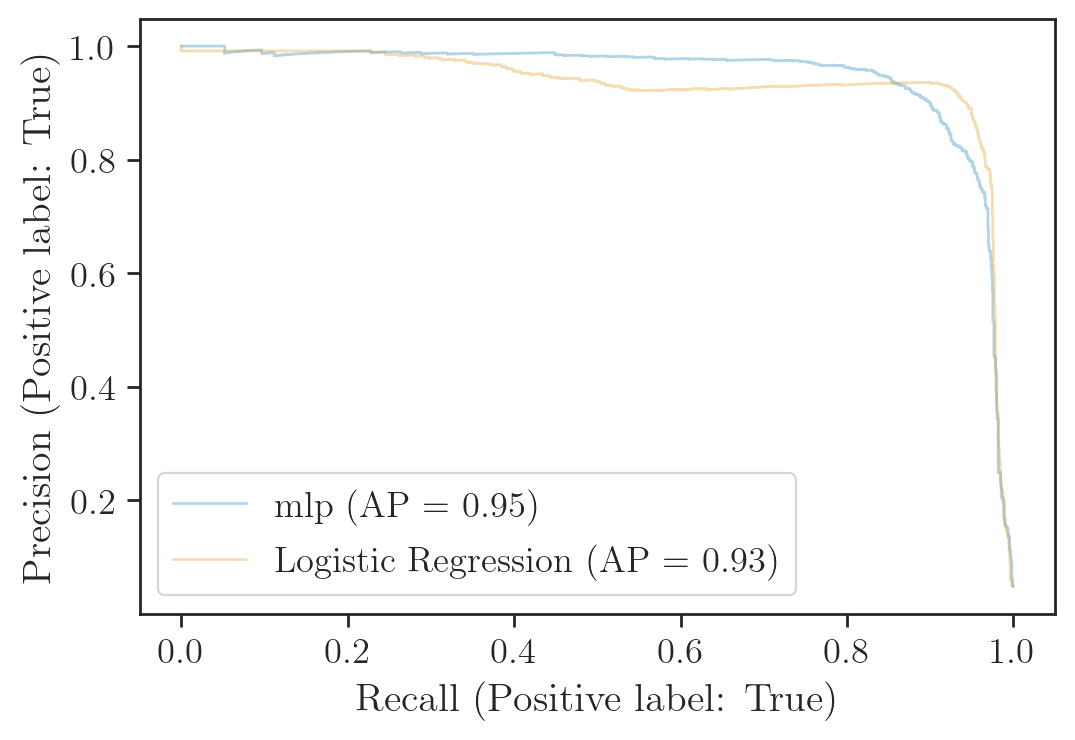

In [34]:
fig, ax = plt.subplots(figsize=fig_size)

classifier = clf.fit(X_transf, y)

X_test = df_test[features + ["assembly_accession", "dataset", "truth", "dataset_cat"]]
X_test = X_test.loc[:, features].copy()
X_test.reset_index(inplace=True, drop=True)

y_test = df_test.loc[:, "truth"]
y_test.reset_index(inplace=True, drop=True)

viz = plot_precision_recall_curve(classifier, X_test, y_test, alpha=0.3, lw=1, ax=ax, name=clf_name)
interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
interp_precision[0] = 1.0
precisions.append(interp_precision)
average_precisions.append(viz.average_precision)
y_pred = classifier.predict(X_transf[test])
# print(f"Dataset: {categories[i]}")
print(f"F1: {f1_score(y.loc[test], y_pred)}")
print(f"Precision: {precision_score(y.loc[test], y_pred)}")
print(f"Recall: {recall_score(y.loc[test], y_pred)}")
print(f"Num Predicted: {y_pred.sum()}")

classifier = logistic.fit(X_transf, y)

viz = plot_precision_recall_curve(classifier, X_test, y_test, alpha=0.3, lw=1, ax=ax, name="Logistic Regression")
interp_precision = np.interp(mean_recall, viz.recall[::-1], viz.precision[::-1])
interp_precision[0] = 1.0
precisions.append(interp_precision)
average_precisions.append(viz.average_precision)
y_pred = classifier.predict(X_transf[test])
# print(f"Dataset: {categories[i]}")
print(f"F1: {f1_score(y.loc[test], y_pred)}")
print(f"Precision: {precision_score(y.loc[test], y_pred)}")
print(f"Recall: {recall_score(y.loc[test], y_pred)}")
print(f"Num Predicted: {y_pred.sum()}")
pu.save_plot(fig, f"pr_curve.test.{clf_name}")